# Fréchet Means of Persistence Diagrams of Context Vectors for ESM-2 

In [1]:
pip install numpy matplotlib scikit-learn gudhi pot -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# You may need to run this to get the code to work
# conda install pot -q

## An Initial Generic Example of the Fréchet Mean of Persistence Diagrams (a.k.a. the Barycenter Persistence Diagram)

In [3]:
from gudhi.wasserstein.barycenter import lagrangian_barycenter
import numpy as np

dg1 = np.array([[0., 1.], [0, 2], [1, 2], [1.32, 1.87], [0.7, 1.2]])
dg2 = np.array([[0, 1.5], [0.5, 2], [1.2, 2], [1.3, 1.8], [0.4, 0.8]])
dg3 = np.array([[0.2, 1.1], [0.1, 2.2], [1.3, 2.1], [0.5, 0.9], [0.6, 1.1]])
dg4 = np.array([])
pdiagset = [dg1, dg2, dg3, dg4]
bary = lagrangian_barycenter(pdiagset=pdiagset,init=3)

print("Wasserstein barycenter estimated:")
print(bary)


Wasserstein barycenter estimated:
[[0.5375     1.1625    ]
 [1.275      1.925     ]
 [0.29583333 0.87083333]
 [1.44125    1.70375   ]
 [0.65       0.75      ]
 [0.43333333 1.83333333]]


## Another Generic Example with Plots

In [4]:
import gudhi
print("Current gudhi version:", gudhi.__version__)
print("Version >= 3.2.0 is required for this tutorial")

Current gudhi version: 3.8.0
Version >= 3.2.0 is required for this tutorial


In [5]:
# Note: %matplotlib notebook allows for iteractive 3D plot.
#%matplotlib notebook
%matplotlib inline

In [6]:
from gudhi.wasserstein.barycenter import lagrangian_barycenter as bary
from gudhi.persistence_graphical_tools import plot_persistence_diagram

import numpy as np
import matplotlib.pyplot as plt

In [7]:
diag1 = np.array([[0., 1.], [0, 2], [1, 2], [1.32, 1.87], [0.7, 1.2]])
diag2 = np.array([[0, 1.5], [0.5, 2], [1.2, 2], [1.3, 1.8], [0.4, 0.8]])
diag3 = np.array([[0.2, 1.1], [0.1, 2.2], [1.3, 2.1], [0.5, 0.9], [0.6, 1.1]])

diags = [diag1, diag2, diag3]

Text(0.5, 1.0, 'Set of 3 persistence diagrams')

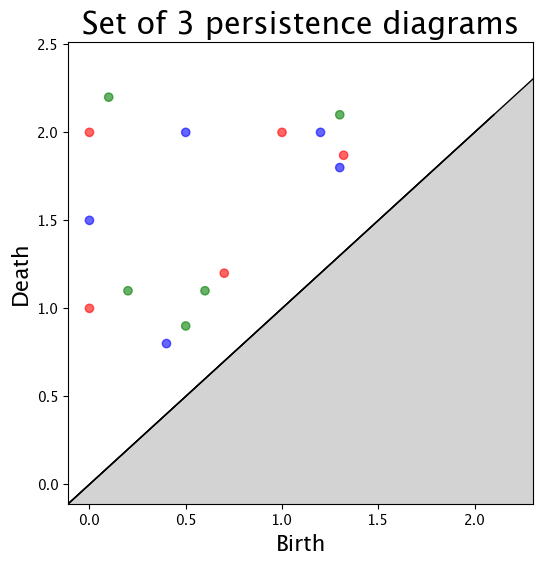

In [8]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
colors=['r', 'b', 'g']
for diag, c in zip(diags, colors):
    plot_persistence_diagram(diag, axes=ax, colormap=c)
ax.set_title("Set of 3 persistence diagrams", fontsize=22)


In [9]:
b, log = bary(diags, 
         init=0,
         verbose=True)  # we initialize our estimation on the first diagram (the red one.)

print("Energy reached by this estimation of the barycenter: E=%.2f." %log['energy'])
print("Convergenced made after %s steps." %log['nb_iter'])

Energy reached by this estimation of the barycenter: E=0.47.
Convergenced made after 2 steps.


In [10]:
G = log["groupings"]

def proj_on_diag(x):
    return ((x[1] + x[0]) / 2, (x[1] + x[0]) / 2)

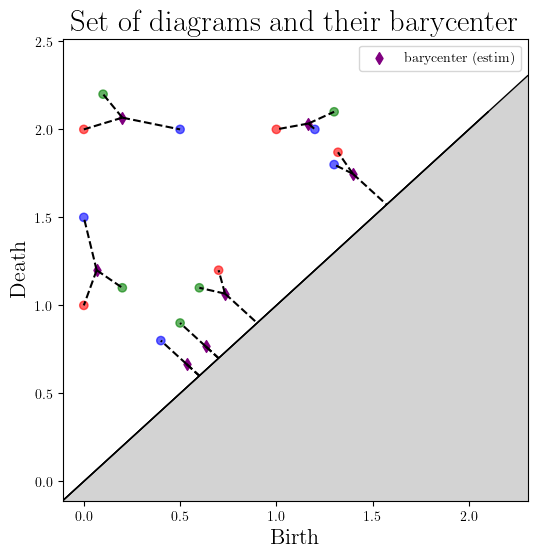

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
colors = ['r', 'b', 'g']

for diag, c in zip(diags, colors):
    plot_persistence_diagram(diag, axes=ax, colormap=c)

def plot_bary(b, diags, groupings, axes):
    # n_y = len(Y.points)
    for i in range(len(diags)):
        indices = G[i]
        n_i = len(diags[i])

        for (y_j, x_i_j) in indices:
            y = b[y_j]
            if y[0] != y[1]:
                if x_i_j >= 0:  # not mapped with the diag
                    x = diags[i][x_i_j]
                else:  # y_j is matched to the diagonal
                    x = proj_on_diag(y)
                ax.plot([y[0], x[0]], [y[1], x[1]], c='black',
                        linestyle="dashed")

    ax.scatter(b[:,0], b[:,1], color='purple', marker='d', label="barycenter (estim)")
    ax.legend()
    ax.set_title("Set of diagrams and their barycenter", fontsize=22)

plot_bary(b, diags, G, axes=ax)


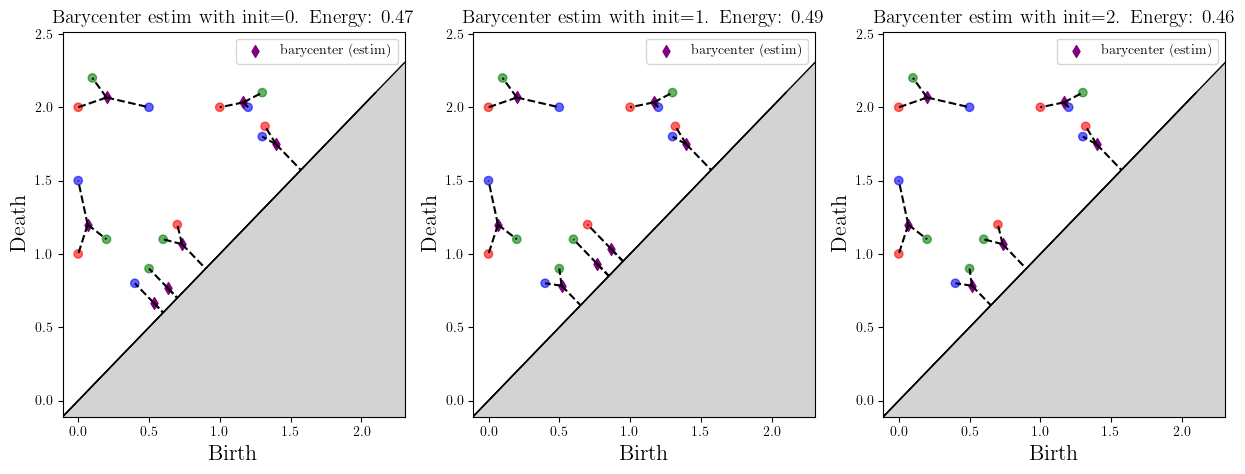

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

colors = ['r', 'b', 'g']

for i, ax in enumerate(axs):
    for diag, c in zip(diags, colors):
        plot_persistence_diagram(diag, axes=ax, colormap=c)

    b, log = bary(diags, init=i, verbose=True)
    e = log["energy"]
    G = log["groupings"]
    # print(G)
    plot_bary(b, diags, groupings=G, axes=ax)
    ax.set_title("Barycenter estim with init=%s. Energy: %.2f" %(i, e), fontsize=14)

## Barycenter Example with Four Protein Sequences

In what follows we will compute the Fréchet mean (or barycenter) of four persistence diagrams obatined from computing the persistent homology of the context vectors computed by an individual attention head of `ESM-2`. 

In [13]:
text = ["VHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFF"]

text_2 = ["VHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFES"]

text_3 = ["VHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESF"]

text_4 = ["GLSDGEWQQVLNVWGKVEADIPGHGQEVLIRLFKGHPETLEKFDR"]

In [14]:
# Let's start by importing necessary libraries
from transformers import EsmModel, AutoTokenizer
import gudhi as gd
import numpy as np
import torch
from scipy.spatial.distance import pdist, jensenshannon, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from gudhi.hera import wasserstein_distance

def compute_output(sentence, layer, head):
    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
    model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")   


    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O

# Set the layer and head to use for computation
layer = 3
head = 2

# Compute the context vectors for each text in the corpus
context = [compute_output(t, layer, head) for t in text]
context_2 = [compute_output(t, layer, head) for t in text_2]
context_3 = [compute_output(t, layer, head) for t in text_3]
context_4 = [compute_output(t, layer, head) for t in text_4]

Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model chec

## Computing the Persistent Homology of the Collocation or Multiword Expression

In [16]:
from scipy.spatial import distance_matrix
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer

def compute_phrase_distances_and_homology(context_vectors, sentence, phrase):
    # Initialize the tokenizer
    tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")

    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = []
    phrase_length = len(phrase_tokens)
    for i in range(len(sentence_tokens) - phrase_length + 1):
        if sentence_tokens[i:i+phrase_length] == phrase_tokens:
            phrase_indices.extend(range(i, i+phrase_length))
            break

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[0, phrase_indices]

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Print the tokens of the sub-collection and their context vectors
    # print(f'Tokens of the sub-collection: {tokenizer.convert_ids_to_tokens(phrase_tokens)}')
    # print(f'Context vectors of the sub-collection: {phrase_context_vectors_np}')

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Print the distance matrix
    # print(f'Distance matrix: {distances.shape}')
    # print(f'Distance matrix: {distances}')

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    # Plot the barcode diagram
    # gd.plot_persistence_diagram(persistence=persistent_homology)
    # plt.show()

    return persistent_homology

# Assuming that 'context_vectors' is the tensor of context vectors for your sentence,
# and 'sentence' is your original sentence, you can use the function like this:
diag1 = compute_phrase_distances_and_homology(context[0], text[0], text[0])
diag2 = compute_phrase_distances_and_homology(context_2[0], text_2[0], text_2[0])
diag3 = compute_phrase_distances_and_homology(context_3[0], text_3[0], text_3[0])
diag4 = compute_phrase_distances_and_homology(context_4[0], text_4[0], text_4[0])

In [17]:
print(type(diag1))
print(diag1)

<class 'list'>
[(1, (0.09811431197382867, 0.11842724834222305)), (1, (0.08953496491934132, 0.10396489909926276)), (1, (0.07580763042338, 0.0847997256378334)), (1, (0.10504086596915901, 0.11081181144607605)), (1, (0.09722094728466125, 0.09945444364541094)), (1, (0.08977058394697214, 0.09101605223158107)), (0, (0.0, inf)), (0, (0.0, 0.09286265523735462)), (0, (0.0, 0.0918427279314938)), (0, (0.0, 0.09106108401467551)), (0, (0.0, 0.0900533122229771)), (0, (0.0, 0.08821654850573515)), (0, (0.0, 0.08471213084844535)), (0, (0.0, 0.0835939605245164)), (0, (0.0, 0.0801197310468902)), (0, (0.0, 0.07964428235583271)), (0, (0.0, 0.07932762598142566)), (0, (0.0, 0.0747150301281159)), (0, (0.0, 0.07454954940826442)), (0, (0.0, 0.07399709835817575)), (0, (0.0, 0.07365419755346263)), (0, (0.0, 0.07206605537801802)), (0, (0.0, 0.07188290133229444)), (0, (0.0, 0.07162165606014141)), (0, (0.0, 0.06873344123539385)), (0, (0.0, 0.06744254514336386)), (0, (0.0, 0.06708277444224514)), (0, (0.0, 0.0653362748

In [20]:
def convert_persistence_diagram(diagram, dimension):
    return np.array([point[1] for point in diagram if point[1][1] != np.inf and point[0] == dimension])

# Convert your diagrams
dg1 = convert_persistence_diagram(diag1, 1)
dg2 = convert_persistence_diagram(diag2, 1)
dg3 = convert_persistence_diagram(diag3, 1)
dg4 = convert_persistence_diagram(diag4, 1)

# Now try the barycenter computation again
pdiagset = [dg1, dg2, dg3, dg4]
bary = lagrangian_barycenter(pdiagset=pdiagset,init=3)
print(bary)


[[0.07272055 0.09190809]
 [0.10088342 0.11553712]
 [0.05193209 0.05452511]
 [0.05545235 0.05710111]
 [0.07886907 0.08408971]
 [0.05534306 0.05575815]
 [0.05091841 0.05128485]
 [0.09805851 0.09861688]
 [0.10720497 0.10864771]
 [0.11889805 0.12679751]
 [0.07123579 0.07324044]
 [0.08064701 0.0822148 ]
 [0.06087262 0.06149911]
 [0.09178629 0.09953826]
 [0.08884561 0.09302715]
 [0.10109362 0.10325347]
 [0.0994266  0.10152335]]


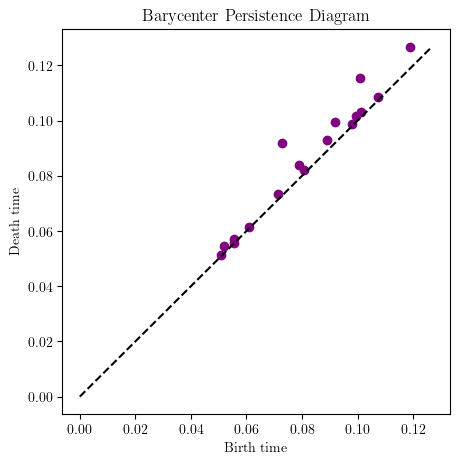

In [26]:
import matplotlib.pyplot as plt

# Convert the barycenter back into a list of tuples format
bary_as_tuples = [(1, tuple(point)) for point in bary]

# Separate birth and death times for plotting
birth_times, death_times = zip(*[point[1] for point in bary_as_tuples])

plt.figure(figsize=(5,5))
plt.scatter(birth_times, death_times, color='purple')
plt.plot([0, max(death_times)], [0, max(death_times)], 'k--')  # diagonal line
plt.title('Barycenter Persistence Diagram')
plt.xlabel('Birth time')
plt.ylabel('Death time')
plt.show()


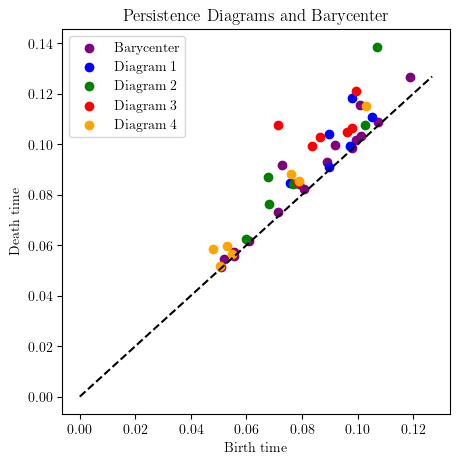

In [29]:
import matplotlib.pyplot as plt

# Convert the barycenter back into a list of tuples format
bary_as_tuples = [(1, tuple(point)) for point in bary]

# Separate birth and death times for plotting
birth_times_bary, death_times_bary = zip(*[point[1] for point in bary_as_tuples])

plt.figure(figsize=(5,5))

# Plot the barycenter
plt.scatter(birth_times_bary, death_times_bary, color='purple', label='Barycenter')

# Plot the original diagrams
colors = ['blue', 'green', 'red', 'orange']
for idx, diag in enumerate([dg1, dg2, dg3, dg4]):
    birth_times, death_times = zip(*diag)
    plt.scatter(birth_times, death_times, color=colors[idx], label=f'Diagram {idx+1}')

plt.plot([0, max(death_times_bary)], [0, max(death_times_bary)], 'k--')  # diagonal line
plt.title('Persistence Diagrams and Barycenter')
plt.xlabel('Birth time')
plt.ylabel('Death time')
plt.legend()
plt.show()
